<a href="https://colab.research.google.com/github/LisaLi1224/Eddymemory/blob/main/eddymemory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import signalz
from signalz.misc import check_type_or_raise
from signalz.generators.gaussian_white_noise import gaussian_white_noise
from signalz.generators.uniform_white_noise import uniform_white_noise
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [2]:
# generate red-noise time series
# source: https://github.com/matousc89/signalz/blob/master/signalz/generators/brownian_noise.py
def brownian_noise(n, leak=0., start=0, std=1., source="gaussian"):
    # check inputs
    check_type_or_raise(n, int, "n")
    check_type_or_raise(leak, float, "leak")
    if not 0. <= leak < 1:
        raise ValueError("Leak must be between 0. and 1.")
    # generate white noise
    if source == "gaussian":
        x = np.random.normal(0, std, n)
    elif source == "uniform":
        x = np.random.uniform(-std / 2., std / 2., n)
    else:
        raise ValueError("Source must be gaussian or uniform")
    # add offset
    x[0] = start
    # integrate the white noise
    for i in range(1, n):
        x[i] += x[i - 1] * (1 - leak)
    return x


In [3]:
time_interval = 2 # corresponding time interval duration in say days
N_points = 2000 # red-noise vector length


# define pre-defined kernel
tau = 0.2
tspan = np.linspace(0, time_interval, N_points)
dt = tspan[1]-tspan[0]
pre_kernel = np.exp(-tspan/tau)
kernel_size = 200 # truncate the kernel to include some small number of points since we are assuming it decays with time
pre_kernel = pre_kernel[:kernel_size] # now kernel has a smaller number of points relative to the Tgradient time series
print('size of pre_kernel: ' + str(len(pre_kernel)))
tspan_kernel = tspan[:kernel_size]
print('size of tspan_kernel: ' + str(len(tspan_kernel)))

tspan_convolved = tspan[len(pre_kernel)-1:] # the correct way of assigning time to the convolved timeseries
print('size of tspan_convolved: ' + str(len(tspan_convolved)))

size of pre_kernel: 200
size of tspan_kernel: 200
size of tspan_convolved: 1801


In [4]:

# red-noise vector length 1000 (5 different temperature gradient)
m_sample = 10000;
temp_grad = np.zeros((m_sample,N_points,1))
F_flux = np.zeros((m_sample,N_points - kernel_size + 1,1))
for i in range(m_sample):
  temp_grad[i,:,0] = brownian_noise(N_points, leak=0.1, start=0, std=1, source='gaussian')
  F_flux[i,:,0] = np.convolve(pre_kernel, temp_grad[i,:,0], mode='valid')*dt

  
F_flux=F_flux/np.std(F_flux);  
temp_grad=temp_grad/np.std(temp_grad);




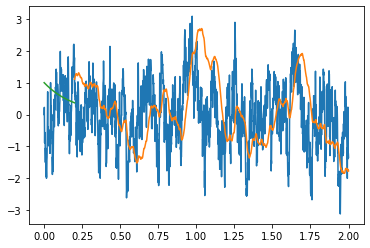

In [5]:
plt.plot(tspan, temp_grad[1,:,0])
plt.plot(tspan_convolved, F_flux[1,:,0])

plt.plot(tspan_kernel, pre_kernel)

In [6]:
np.std(F_flux)

1.0

In [7]:
# build single layer conv1d model
input_series = keras.layers.Input(temp_grad.shape[1:])
output_series = keras.layers.Conv1D(filters=1, padding='valid', kernel_size=kernel_size, strides=1, activation='linear', input_shape=(temp_grad.shape[1:]))(input_series)
model = keras.Model(input_series, output_series)
model.compile(
    optimizer='adam',
    loss= 'mean_squared_error',
    metrics=['mean_squared_error'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 1801, 1)           201       
                                                                 
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


In [8]:
# split train and test sets
X_train, X_rem, y_train, y_rem = train_test_split(temp_grad,F_flux, train_size=0.8)


In [9]:
# train the model
model.fit(X_train, y_train, epochs=50, validation_data = (X_rem, y_rem))



Epoch 1/50
250/250 [==============================] - 14s 56ms/step - loss: 0.3066 - mean_squared_error: 0.3066 - val_loss: 0.0525 - val_mean_squared_error: 0.0525
Epoch 2/50
250/250 [==============================] - 14s 56ms/step - loss: 0.0339 - mean_squared_error: 0.0339 - val_loss: 0.0214 - val_mean_squared_error: 0.0214
Epoch 3/50
250/250 [==============================] - 14s 56ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 4/50
250/250 [==============================] - 15s 59ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 5/50
250/250 [==============================] - 14s 55ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 6/50
250/250 [==============================] - 14s 55ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 7/50
250/2

In [10]:
y_pred = model.predict(X_rem)

63/63 [==============================] - 0s 7ms/step


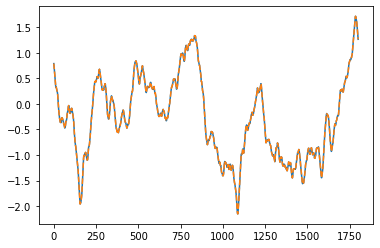

In [11]:
plt.plot(y_rem[2,:,0])
plt.plot(y_pred[2,:,0],'--')

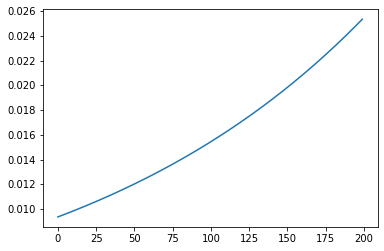

In [17]:
# get the kernel
conv_kernel = model.weights[0][:,0,0]
plt.plot(conv_kernel)
#plt.plot(pre_kernel)